In [97]:
import pandas as pd
import os
import re
from dataclasses import dataclass
import json
%matplotlib inline

In [98]:
jobname_regex = re.compile(r"(?<=: \[)(?P<project>[a-z- 0-9 _]+), (?P<noise_type>[a-z- 0-9_]+)")

In [99]:
test_string = "Test Projects: [shiki, cpu 20]"

res = jobname_regex.search(test_string)
res

<re.Match object; span=(16, 29), match='shiki, cpu 20'>

# Read in all Results

In [100]:
directory = "../artifacts"
jobs_dir = os.listdir(directory)
f"{len(jobs_dir)} jobs found"

'174 jobs found'

In [101]:
@dataclass
class TestResult:
    project: str
    noise_type: str
    dir: str
    test_results: dict[str, dict[str, int]]
    env_vars: dict[str, str]
    job_number: int

    test_df: pd.DataFrame = None

    def __post_init__(self):
        # Compute the test_df
        # Columns: test_name, PASSED, Failed, Skipped, TOTAL RUNS
        test_names = self.test_results.keys()
        passed = [test.get("PASSED", 0) for test in self.test_results.values()]
        failed = [test.get("FAILED", 0) for test in self.test_results.values()]
        skipped = [test.get("SKIPPED", 0) for test in self.test_results.values()]

        self.test_df = pd.DataFrame({
            "test_name": test_names,
            "PASSED": passed,
            "FAILED": failed,
            "SKIPPED": skipped
        })
        self.test_df["TOTAL RUNS"] = self.test_df["PASSED"] + self.test_df["FAILED"]


In [102]:
results: list[TestResult] = []
for job in jobs_dir:
    # check if folder contains a jobname.txt
    if not os.path.exists(os.path.join(directory, job, "jobname.txt")):
        continue

    with open(os.path.join(directory, job, "jobname.txt")) as f:
        job_str = f.read()
    job_re = jobname_regex.search(job_str)

    with open(os.path.join(directory, job, "aggregate-test-results", "aggregated_test_results.json")) as f:
        test_results = json.load(f)

    with open(os.path.join(directory, job, "aggregate-test-results", "environment_variables.json")) as f:
        env_vars = json.load(f)

    results.append(TestResult(
        project=job_re.group("project"),
        noise_type=job_re.group("noise_type"),
        dir=os.path.join(directory, job),
        test_results=test_results,
        env_vars=env_vars,
        job_number=int(job)
    ))

In [103]:
f"parsed {len(results)} results"

'parsed 173 results'

In [104]:
x =results[1].test_df.sort_values("FAILED")

In [105]:
results[50].test_df

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS
0,chromium/gatsby-script-off-main-thread.spec.ts...,100,0,0,100
1,chromium/gatsby-script-off-main-thread.spec.ts...,0,0,100,0
2,chromium/gatsby-script-off-main-thread.spec.ts...,0,0,100,0


# Remove job with the same project and noise type

In [106]:
results_dict : dict[tuple[str, str], TestResult] = {}
for result in results:
    key = (result.project, result.noise_type)
    if key in results_dict:
        if results_dict[key].job_number < result.job_number:
            results_dict[key] = result
    else:
        results_dict[key] = result

In [107]:
f"Filtered {len(results) - len(results_dict)} results"

'Filtered 26 results'

In [108]:
results = list(results_dict.values())

# Single Analysis DF of all results

Columns: project
Rows: noise_type
Element: flakyness in %

## Formula

$$
flakyness = \begin{cases}
0, all\ tests\ failed\\
\frac{Failed\ Tests}{Total\ Test\ Runs}, else
\end{cases}
$$

In [109]:
# define a function to compute the flakyness
def compute_flakyness(df: pd.DataFrame) -> float:
    lambda x: 0 if x["PASSED"] == 0 else x["FAILED"] / x["TOTAL RUNS"]

    df["flakyness"] = df.apply(lambda x: 0 if x["PASSED"] == 0 else x["FAILED"] / x["TOTAL RUNS"], axis=1)
    return df["flakyness"].mean()

flakyness = [compute_flakyness(result.test_df) for result in results]

In [110]:
noise_types: set[str] = set()
projects: set[str] = set()

for (pj, nt) in results_dict:
    noise_types.add(nt)
    projects.add(pj)

print(f"Got noise_types: {noise_types} and projects {projects}")

Got noise_types: {'baseline', 'bandwidth', 'packet_loss_20', 'cpu20', 'memory', 'cpu50', 'network_delay', 'disk', 'packet_loss_70', 'packet_loss', 'interrupt'} and projects {'storybook', 'ionic-framework', 'material-ui', 'lenster', 'logseq', 'floating-ui', 'docs', 'gatsby', 'insomnia', 'playwright', 'remix', 'rocket-chat', 'dev-roadmap', 'cal', 'quill', 'shiki'}


In [111]:
overview_dict: dict[str, list[float]] = {}

for noise in noise_types:
    for project in projects:
        curr_val: list[float] = overview_dict.get(project, [])

        val = float("nan")

        if (project, noise) in results_dict:
            val = compute_flakyness(results_dict[(project, noise)].test_df)
        else:
            f"Missing data for project {project} and noise type {noise}"
        curr_val.append(val)
        overview_dict[project] = curr_val

overview = pd.DataFrame(overview_dict, index=list(noise_types))

In [112]:
overview

,storybook,ionic-framework,material-ui,lenster,logseq,floating-ui,docs,gatsby,insomnia,playwright,remix,rocket-chat,dev-roadmap,cal,quill,shiki
baseline,0.009429,0.002079,0.000000,0.000264,0.228221,0.0,0.0,0.0,0.008220,0.000075,0.000429,0.035184,0.065385,0.033028,0.013333,0.000000
bandwidth,0.009619,NaN,0.000417,0.000000,0.218522,0.0,0.0,0.0,0.006944,0.000082,0.000521,0.203623,0.085897,0.034404,0.003333,0.000000
packet_loss_20,NaN,NaN,0.005000,0.002709,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
cpu20,0.010000,0.000247,0.000000,0.000052,0.140308,0.0,0.0,0.0,0.018519,0.000084,NaN,0.021943,0.046667,0.039450,0.080000,0.000000
memory,NaN,0.000375,0.000000,0.000105,0.205375,0.0,0.0,0.0,0.008239,0.000051,0.000123,0.017903,0.078205,0.040826,0.010000,0.000000
cpu50,NaN,NaN,0.000000,0.000106,0.131902,0.0,0.0,0.0,0.013593,0.000186,0.000521,0.016944,0.060256,0.039908,0.000000,0.000000
network_delay,0.008476,NaN,0.000417,0.000785,0.227870,0.0,0.0,0.0,0.000278,0.000016,0.000107,0.017097,0.078205,0.047706,0.000000,0.000000
disk,0.017771,0.000358,0.000000,0.000053,0.012038,0.0,0.0,0.0,0.030093,0.000032,0.000322,0.027694,0.061795,0.043153,0.070000,0.000000
packet_loss_70,NaN,NaN,NaN,0.028147,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
packet_loss,0.009048,0.000520,0.358122,0.019015,0.131839,0.0,0.0,0.0,0.010621,0.000413,0.000475,0.023977,0.085897,0.048165,0.513333,0.231667


<Axes: >

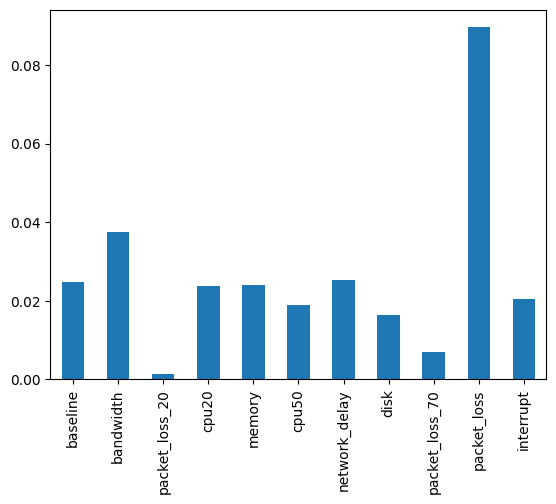

In [113]:
overview.T.mean().plot(kind="bar")

<Axes: >

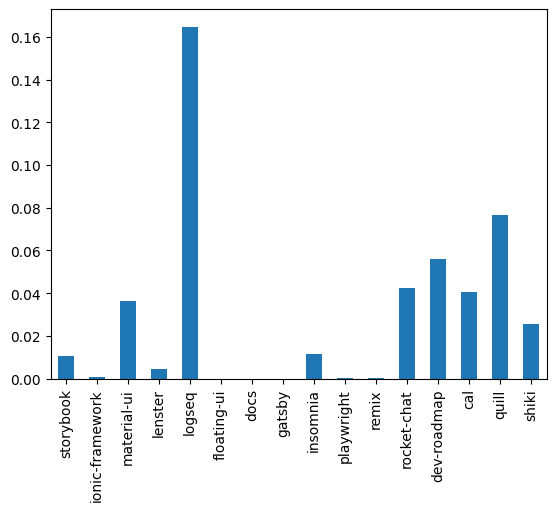

In [114]:
overview.mean().plot(kind="bar")

In [142]:
## Function to compute the flakyness by noise type for each test

def compute_flakyness_per_test_by_noise_type(project_name: str)->pd.DataFrame:
    # get all results for the project
    project_results = [res for res in results if res.project == project_name]


    # get all test names
    test_names = set()
    for res in project_results:
        test_names.update(res.test_df["test_name"])

    # create a dataframe with the test names as index and noise types as columns
    flakiness_df = pd.DataFrame(index=list(test_names), columns=list(noise_types))

    # fill the dataframe with the flakiness
    for res in project_results:
        for noise_type in noise_types:
            if (res.project, noise_type) in results_dict:
                flakiness_df.loc[:, noise_type] = compute_flakyness(results_dict[(res.project, noise_type)].test_df)
            else:
                flakiness_df.loc[:, noise_type] = float("nan")

    return flakiness_df

def compute_flakyness_over_baseline(df: pd.DataFrame)->pd.DataFrame:
    baseline = df["baseline"]
    df = df.drop(columns=["baseline"])
    return df.apply(lambda x: x - baseline, axis=0)

# Single Analysis of each Project

## Logseq

In [157]:
proj = "Logseq"

<Axes: title={'center': 'Flakiness by Noise Type Logseq'}>

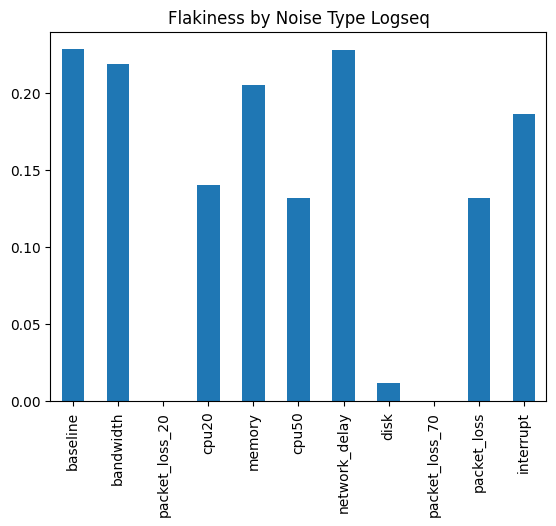

In [158]:
overview["logseq"].T.plot(kind="bar", title="Flakiness by Noise Type Logseq")

In [159]:
results_dict[("logseq", "baseline")].test_df

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS,flakyness
0,/accessibility.spec.ts/should not have any aut...,20,0,0,20,0.00
1,"/basic.spec.ts/create page and blocks, save to...",20,0,0,20,0.00
2,/basic.spec.ts/delete and backspace,19,1,0,20,0.05
3,/basic.spec.ts/selection,20,0,0,20,0.00
4,/basic.spec.ts/template,20,0,0,20,0.00
...,...,...,...,...,...,...
158,/window.spec.ts/window should not be maximized...,20,0,0,20,0.00
159,/window.spec.ts/window should be maximized and...,20,0,0,20,0.00
160,/window.spec.ts/window should be restored and ...,20,0,0,20,0.00
161,/window.spec.ts/window controls should be hidd...,20,0,0,20,0.00


"whiteboard.spec.ts/Create an empedded page" Code:
```typescript
test('Create an embedded page', async ({ page }) => {
  const canvas = await page.waitForSelector('.logseq-tldraw')
  await canvas.dblclick({
    position: {
      x: 150,
      y: 150,
    },
  })

  const quickAdd$ = page.locator('.tl-quick-search')
  await expect(quickAdd$).toBeVisible()

  await page.fill('.tl-quick-search input', 'My page')
  await quickAdd$
    .locator('div[data-index="1"] .tl-quick-search-option')
    .first()
    .click()

  await expect(quickAdd$).toBeHidden()
  await expect(page.locator('.tl-logseq-portal-header a')).toContainText('My page')
})
```

Flaknyess from the dblclick function? - unlikely this function is flaky as well:
```typescript
test('undo the group deletion', async ({ page }) => {
  await page.keyboard.press(modKey + '+z')

  await expect(page.locator('.logseq-tldraw .tl-group-container')).toHaveCount(1)
  await expect(page.locator('.logseq-tldraw .tl-box-container')).toHaveCount(2)
})
```

In [160]:
results_dict[("logseq", "baseline")].test_df.sort_values("FAILED")

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS,flakyness
0,/accessibility.spec.ts/should not have any aut...,20,0,0,20,0.00
90,/page-rename.spec.ts/page rename test,20,0,0,20,0.00
89,/logseq-url.spec.ts/Logseq URLs (same graph),20,0,0,20,0.00
88,/logseq-api.spec.ts/block related apis,20,0,0,20,0.00
87,/hotkey.spec.ts/insert link #3278,20,0,0,20,0.00
...,...,...,...,...,...,...
133,/whiteboards.spec.ts/undo the color switch,1,19,0,20,0.95
134,/whiteboards.spec.ts/undo the shape conversion,1,19,0,20,0.95
136,/whiteboards.spec.ts/move arrow to back,1,19,0,20,0.95
138,/whiteboards.spec.ts/undo the move action,1,19,0,20,0.95


In [161]:
tbn = compute_flakyness_per_test_by_noise_type("logseq")
tbn

,baseline,bandwidth,packet_loss_20,cpu20,memory,cpu50,network_delay,disk,packet_loss_70,packet_loss,interrupt
/shui/table.spec.js/table can configure logseq.table.borders,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607
/whiteboards.spec.ts/redo the rectangle action,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607
/editor.spec.ts/moving cursor inside of brackets when autocomplete menu is closed should NOT open autocomplete menu,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607
/window.spec.ts/window controls should be hidden on fullscreen mode,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607
/context-menu.spec.ts/close context menu on esc,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607
...,...,...,...,...,...,...,...,...,...,...,...
/whiteboards.spec.ts/copy/paste url to create an iFrame shape,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607
/window.spec.ts/window should not be maximized on first launch,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607
/whiteboards.spec.ts/undo the rectangle action,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607
/paste.spec.ts/property text deleted on Ctrl+C when its value mixes [[link]] and other text #9100,0.228221,0.218522,NaN,0.140308,0.205375,0.131902,0.22787,0.012038,NaN,0.131839,0.186607


Most flaky test:  /shui/table.spec.js/table can configure logseq.table.borders


<Axes: title={'center': 'Flakiness of most flaky test of Logseq'}>

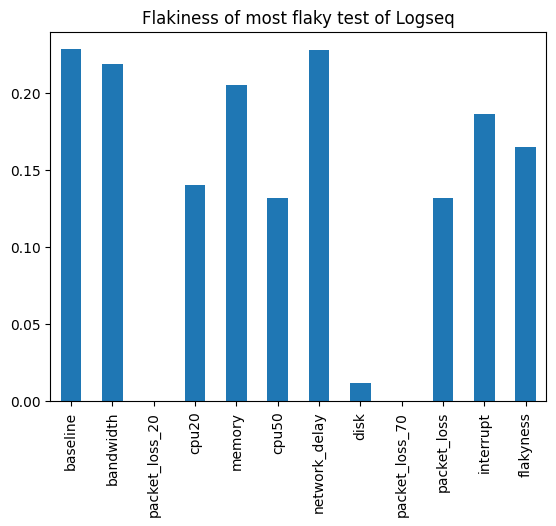

In [162]:
# get most flaky test
tbn["flakyness"] = tbn.mean(axis=1)
mostflaky = tbn.sort_values("flakyness", ascending=False).head(1).index[0]
print("Most flaky test: ", mostflaky)
tbn.loc[mostflaky].plot(kind="bar", title=f"Flakiness of most flaky test of {proj}")

In [163]:
# overflakyness
test = tbn
fob = compute_flakyness_over_baseline(test)

<Axes: title={'center': 'Flakiness over Baseline of Logseq'}>

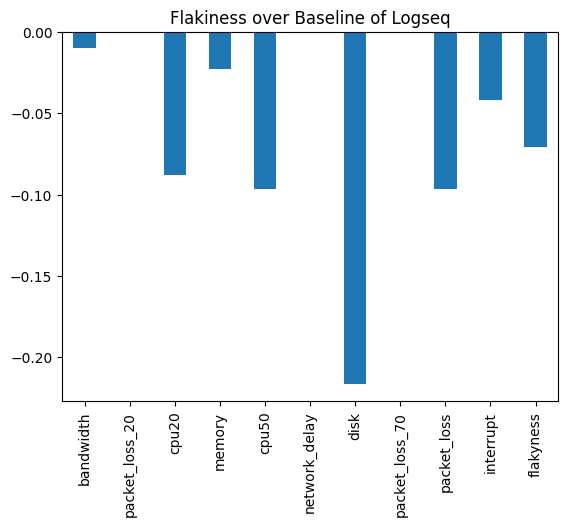

In [164]:
# get most flaky test
fob["flakyness"] = fob.mean(axis=1)
mostflaky = fob.sort_values("flakyness", ascending=False).head(1).index[0]
#print("Most flaky test: ", mostflaky)
fob.loc[mostflaky].plot(kind="bar",  title=f"Flakiness over Baseline of {proj}")

## Gatsby

No flaking tests why?

<Axes: >

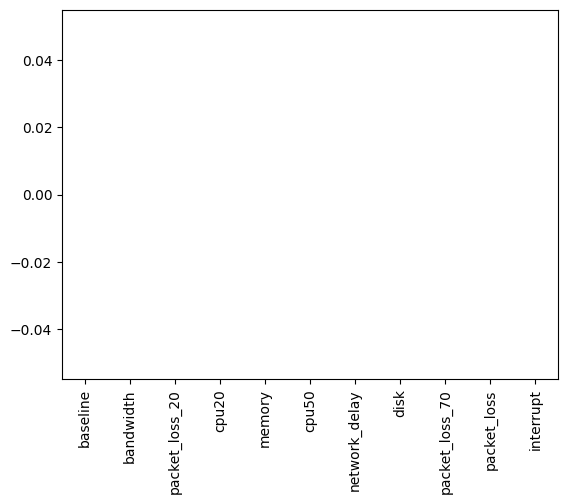

In [153]:
overview["gatsby"].T.plot(kind="bar")

In [119]:
results_dict[("gatsby", "baseline")].test_df

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS,flakyness
0,chromium/gatsby-script-off-main-thread.spec.ts...,100,0,0,100,0.0
1,chromium/gatsby-script-off-main-thread.spec.ts...,0,0,100,0,0.0
2,chromium/gatsby-script-off-main-thread.spec.ts...,0,0,100,0,0.0


In [120]:
results_dict[("gatsby", "disk")].test_df

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS,flakyness
0,chromium/gatsby-script-off-main-thread.spec.ts...,100,0,0,100,0.0
1,chromium/gatsby-script-off-main-thread.spec.ts...,0,0,100,0,0.0
2,chromium/gatsby-script-off-main-thread.spec.ts...,0,0,100,0,0.0


=> Gatsby only executes that single test case => no flakyness

## Cal.com

In [148]:
proj = "cal"

<Axes: title={'center': 'Flakiness of cal'}>

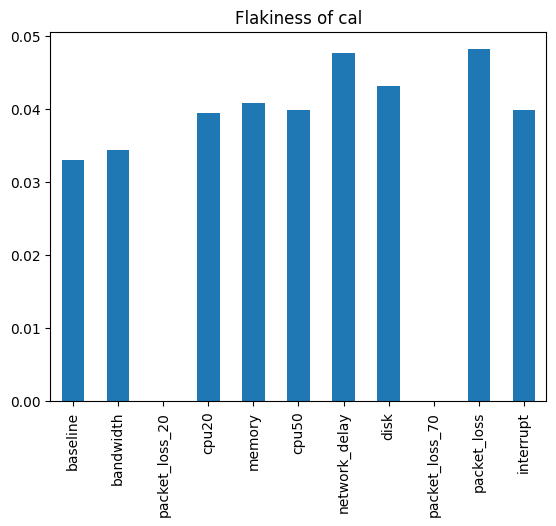

In [149]:
overview["cal"].T.plot(kind="bar", title=f"Flakiness of {proj}")

In [123]:
results_dict[("cal", "baseline")].test_df

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS,flakyness
0,@calcom/web/apps/web/playwright/app-store.e2e....,20,0,0,20,0.0
1,@calcom/web/apps/web/playwright/app-store.e2e....,20,0,0,20,0.0
2,@calcom/web/apps/web/playwright/app-store.e2e....,20,0,0,20,0.0
3,@calcom/web/apps/web/playwright/auth/auth-inde...,20,0,0,20,0.0
4,@calcom/web/apps/web/playwright/auth/delete-ac...,10,10,0,20,0.5
...,...,...,...,...,...,...
104,@calcom/web/apps/web/playwright/trial.e2e.ts/T...,0,0,20,0,0.0
105,@calcom/web/apps/web/playwright/webhook.e2e.ts...,20,0,0,20,0.0
106,@calcom/web/apps/web/playwright/webhook.e2e.ts...,20,0,0,20,0.0
107,@calcom/web/apps/web/playwright/webhook.e2e.ts...,20,0,0,20,0.0


In [136]:
tbn = compute_flakyness_per_test_by_noise_type("cal")
tbn

,baseline,bandwidth,packet_loss_20,cpu20,memory,cpu50,network_delay,disk,packet_loss_70,packet_loss,interrupt
@calcom/web/apps/web/playwright/booking-seats.e2e.ts/Reschedule for booking with seats -- new-booker › Should reschedule booking with seats and if everyone rescheduled it should be deleted,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908
@calcom/web/apps/web/playwright/manage-booking-questions.e2e.ts/Manage Booking Questions › For User EventType -- new-booker › Do a booking with a user added question and verify a few thing in b/w,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908
@calcom/web/apps/web/playwright/managed-event-types.e2e.ts/Managed Event Types tests › Can create managed event type,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908
@calcom/web/apps/web/playwright/booking-pages.e2e.ts/pro user -- new-booker › book an event first day in next month,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908
@calcom/web/apps/web/playwright/change-password.e2e.ts/Change Password Test › change password,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908
...,...,...,...,...,...,...,...,...,...,...,...
@calcom/web/apps/web/playwright/dynamic-booking-pages.e2e.ts/dynamic booking,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908
@calcom/web/apps/web/playwright/change-username.e2e.ts/Change username on settings › User can change username,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908
@calcom/web/apps/web/playwright/reschedule.e2e.ts/Reschedule Tests -- old-booker › Paid rescheduling should go to success page,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908
@calcom/web/apps/web/playwright/booking-seats.e2e.ts/Reschedule for booking with seats -- old-booker › Should reschedule booking with seats,0.033028,0.034404,NaN,0.03945,0.040826,0.039908,0.047706,0.043153,NaN,0.048165,0.039908


<Axes: title={'center': 'Flakiness of cal'}>

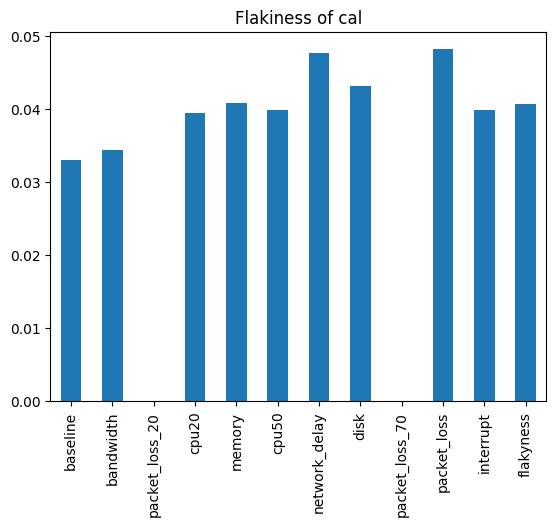

In [150]:
# get most flaky test
tbn["flakyness"] = tbn.mean(axis=1)
mostflaky = tbn.sort_values("flakyness", ascending=False).head(1).index[0]
#print("Most flaky test: ", mostflaky)
tbn.loc[mostflaky].plot(kind="bar", title=f"Flakiness of {proj}")

In [151]:
# overflakyness
test = tbn
fob = compute_flakyness_over_baseline(test)

<Axes: title={'center': 'Flakiness over Baseline of cal'}>

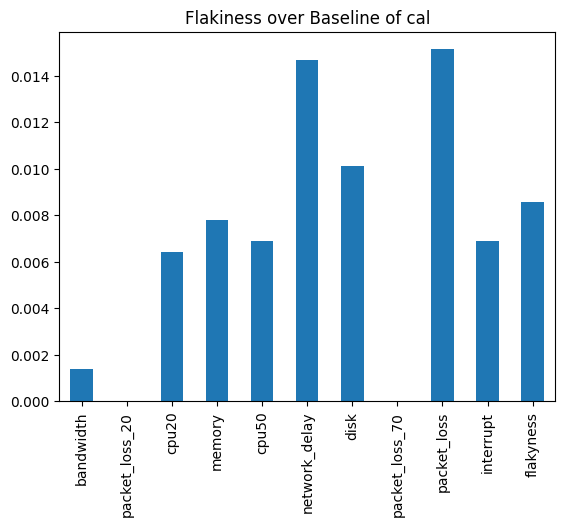

In [152]:
# get most flaky test
fob["flakyness"] = fob.mean(axis=1)
mostflaky = fob.sort_values("flakyness", ascending=False).head(1).index[0]
#print("Most flaky test: ", mostflaky)
fob.loc[mostflaky].plot(kind="bar",  title=f"Flakiness over Baseline of {proj}")

## Storybook

<Axes: title={'center': 'Flakiness of storybook'}>

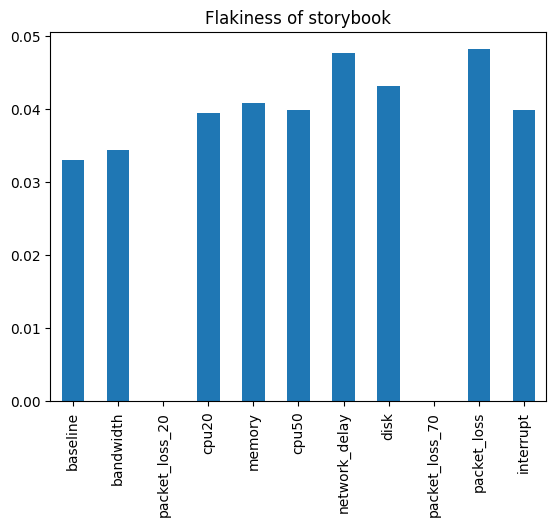

In [166]:
proj = "storybook"
overview["cal"].T.plot(kind="bar", title=f"Flakiness of {proj}")

In [168]:
results_dict[(proj, "baseline")].test_df

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS,flakyness
0,chromium/addon-actions.spec.ts/addon-actions ›...,100,0,0,100,0.00
1,chromium/addon-backgrounds.spec.ts/addon-backg...,100,0,0,100,0.00
2,chromium/addon-backgrounds.spec.ts/addon-backg...,100,0,0,100,0.00
3,chromium/addon-backgrounds.spec.ts/addon-backg...,100,0,0,100,0.00
4,chromium/addon-backgrounds.spec.ts/addon-backg...,100,0,0,100,0.00
...,...,...,...,...,...,...
100,webkit/framework-nextjs.spec.ts/Next.js › next...,0,0,100,0,0.00
101,webkit/framework-nextjs.spec.ts/Next.js › next...,0,0,100,0,0.00
102,webkit/json-files.spec.ts/JSON files › should ...,100,0,0,100,0.00
103,webkit/preview-web.spec.ts/preview-web › shoul...,65,35,0,100,0.35


In [169]:
tbn = compute_flakyness_per_test_by_noise_type(proj)
tbn

,baseline,bandwidth,packet_loss_20,cpu20,memory,cpu50,network_delay,disk,packet_loss_70,packet_loss,interrupt
firefox/framework-nextjs.spec.ts/Next.js › next/router › should trigger forward action,0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN
chromium/addon-docs.spec.ts/addon-docs › should not run autoplay stories without parameter,0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN
firefox/addon-backgrounds.spec.ts/addon-backgrounds › docs pages › button should appear for unattached .mdx files,0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN
chromium/addon-docs.spec.ts/addon-docs › should render errors,0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN
"webkit/preview-web.spec.ts/preview-web › should pass over shortcuts, but not from play functions, docs",0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN
...,...,...,...,...,...,...,...,...,...,...,...
webkit/framework-nextjs.spec.ts/Next.js › next/router › should trigger push action,0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN
firefox/addon-docs.spec.ts/addon-docs › source snippet should not change in stories block,0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN
chromium/addon-backgrounds.spec.ts/addon-backgrounds › should have a dark background,0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN
firefox/addon-docs.spec.ts/addon-docs › should provide source snippet,0.009429,0.009619,NaN,0.01,NaN,NaN,0.008476,0.017771,NaN,0.009048,NaN


<Axes: title={'center': 'Flakiness of storybook'}>

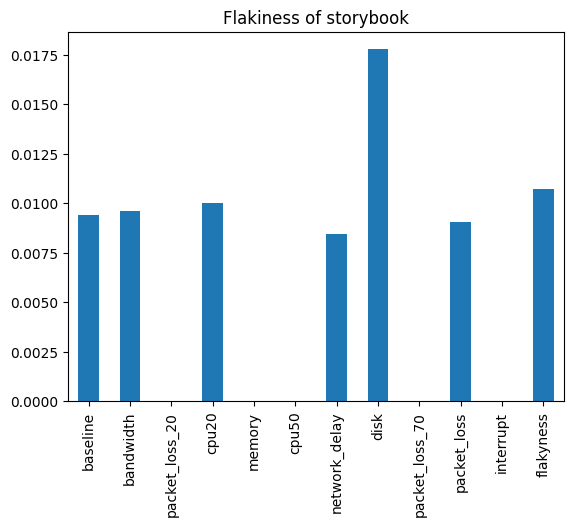

In [170]:
# get most flaky test
tbn["flakyness"] = tbn.mean(axis=1)
mostflaky = tbn.sort_values("flakyness", ascending=False).head(1).index[0]
#print("Most flaky test: ", mostflaky)
tbn.loc[mostflaky].plot(kind="bar", title=f"Flakiness of {proj}")

In [171]:
# overflakyness
test = tbn
fob = compute_flakyness_over_baseline(test)
fob

,bandwidth,packet_loss_20,cpu20,memory,cpu50,network_delay,disk,packet_loss_70,packet_loss,interrupt,flakyness
firefox/framework-nextjs.spec.ts/Next.js › next/router › should trigger forward action,0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295
chromium/addon-docs.spec.ts/addon-docs › should not run autoplay stories without parameter,0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295
firefox/addon-backgrounds.spec.ts/addon-backgrounds › docs pages › button should appear for unattached .mdx files,0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295
chromium/addon-docs.spec.ts/addon-docs › should render errors,0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295
"webkit/preview-web.spec.ts/preview-web › should pass over shortcuts, but not from play functions, docs",0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295
...,...,...,...,...,...,...,...,...,...,...,...
webkit/framework-nextjs.spec.ts/Next.js › next/router › should trigger push action,0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295
firefox/addon-docs.spec.ts/addon-docs › source snippet should not change in stories block,0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295
chromium/addon-backgrounds.spec.ts/addon-backgrounds › should have a dark background,0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295
firefox/addon-docs.spec.ts/addon-docs › should provide source snippet,0.00019,NaN,0.000571,NaN,NaN,-0.000952,0.008343,NaN,-0.000381,NaN,0.001295


<Axes: title={'center': 'Flakiness over Baseline of storybook'}>

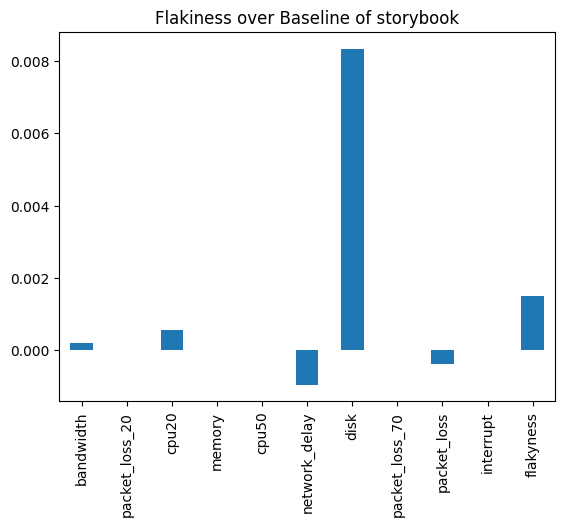

In [172]:
# get most flaky test
fob["flakyness"] = fob.mean(axis=1)
mostflaky = fob.sort_values("flakyness", ascending=False).head(1).index[0]
#print("Most flaky test: ", mostflaky)
fob.loc[mostflaky].plot(kind="bar",  title=f"Flakiness over Baseline of {proj}")

# Network lantency

In [ ]:
lantency = ["baseline", "network_delay"]
lantency_df = overview.loc[lantency]
lantency_df.sort_index(axis=1, inplace=True)

In [ ]:
ax = lantency_df.T.plot.bar(rot=90, title=f"Flakiness between Baseline and  network lantency")

# Network bandwidth

In [ ]:
bandwidth = ["baseline", "bandwidth"]
bandwidth_df = overview.loc[bandwidth]
bandwidth_df.sort_index(axis=1, inplace=True)

In [ ]:
ax = bandwidth_df.T.plot.bar(rot=90, title=f"Flakiness between Baseline and bandwidth limit")

# Compare Packet loss

In [ ]:
packet_noises = ["baseline", "packet_loss_20", "packet_loss", "packet_loss_70"]
packet_df = overview.loc[["baseline", "packet_loss_20", "packet_loss", "packet_loss_70"]]
packet_df.sort_index(axis=1, inplace=True)


In [ ]:
ax = packet_df.T.plot.bar(rot=90, title=f"Flakiness between Baseline and packet loss")

# Disk noise

In [ ]:
disk_noises = ["baseline", "disk"]

disk_df = overview.loc[disk_noises]
disk_df.sort_index(axis=1, inplace=True)

In [ ]:
ax = disk_df.T.plot.bar(rot=90, title=f"Flakiness between Baseline and disk")

# Compare CPU noise

In [ ]:
cpu_noises = ["baseline", "cpu20", "cpu50"]

cpu_df = overview.loc[cpu_noises]

cpu_df.sort_index(axis=1, inplace=True)


In [ ]:
ax = cpu_df.T.plot.bar(rot=90, title=f"Flakiness between Baseline and cpu limit")

# Memory

In [ ]:
memory_noises = ["baseline", "memory"]

memory_df = overview.loc[memory_noises]
memory_df.sort_index(axis=1, inplace=True)

In [ ]:
ax = memory_df.T.plot.bar(rot=90, title=f"Flakiness between Baseline and memory noise")

# Interrupt

In [ ]:
interrupt_noises = ["baseline", "interrupt"]

interrupt_df = overview.loc[interrupt_noises]
interrupt_df.sort_index(axis=1, inplace=True)

In [ ]:
ax = interrupt_df.T.plot.bar(rot=90, title=f"Flakiness between Baseline and interrupts")

Projects TBD: [shiki, docs, material-ui, insomnia, remix, quill, theia, dev-roadmap, rocket-chat, floating-ui, playwright, lenster, ionic-framework]